In [1]:
from typing import Any
from sklearn.datasets import make_blobs
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import top_k_accuracy_score
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from itertools import compress

In [2]:
d = 2
N = 500
n_centers = 5
X, y = make_blobs(n_samples=[N // n_centers] * n_centers)
is_test = y == 3
is_test[np.random.rand(N) > 0.2] = 1
X_train = X[~is_test]
X_test = X[is_test]
y_train = y[~is_test]
y_test = y[is_test]


nu = 0.5

near_p = 1e-3
far_p = 1e-3
l_r = 0.1

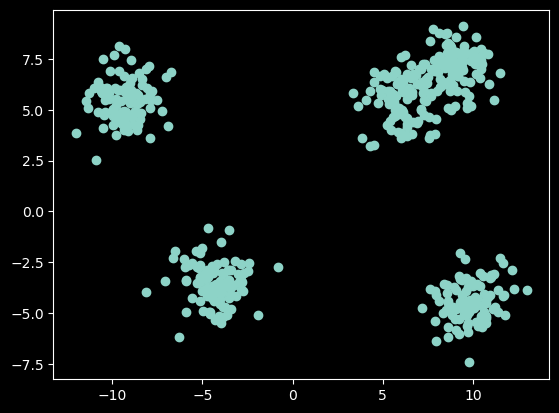

In [3]:
plt.scatter(*X.T)

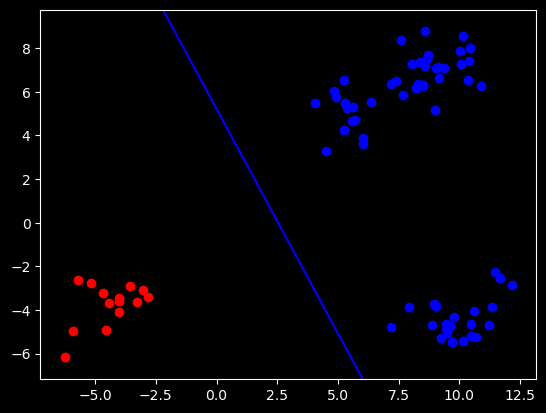

In [4]:
from sklearn.svm import LinearSVC

svc = LinearSVC(max_iter=int(1e4)).fit(X_train, y_train == 0)
svc.intercept_ += 0.5
lbls = svc.decision_function(X_train) > 0
ax = plt.gca()
ax.scatter(*(X_train[lbls]).T, c="r")
ax.scatter(*(X_train[~lbls]).T, c="b")
DecisionBoundaryDisplay.from_estimator(
    svc, X_train, plot_method="contour", levels=[0], colors="b", ax=ax
)

In [5]:
from sklearn.base import ClassifierMixin, BaseEstimator


class BinaryOSRSVM(BaseEstimator, ClassifierMixin):
    def __init__(self, near_p=1.6, far_p=4, l_r=1) -> None:
        self.near_p = near_p
        self.far_p = far_p
        self.l_r = l_r

    def fit_svm(self, X, y):
        from sklearn.svm import LinearSVC

        base_svm = LinearSVC(max_iter=int(1e4)).fit(X, y)

        self.w = base_svm.coef_[0]
        gallery_scores_unsorted = X @ self.w
        sort_permutation = np.argsort(X @ self.w)

        self.gallery_labels = y[sort_permutation]
        self.gallery_scores = gallery_scores_unsorted[sort_permutation]
        self.margins = np.diff(self.gallery_scores)

        positive_idxs = np.argwhere(self.gallery_labels)[:, 0]
        self.near_idx = positive_idxs[0]
        self.far_idx = positive_idxs[-1]
        self.pos_slab_width = (
            self.gallery_scores[positive_idxs[-1]]
            - self.gallery_scores[positive_idxs[0]]
        )

        self.max_idx = self.gallery_scores.shape[0] - 1
        self.far_idx = self.max_idx

    @property
    def near_plane_offset(self):
        if hasattr(self, "_near_s"):
            return self._near_s

        score = self.gallery_scores[self.near_idx]
        if hasattr(self, "near_offset"):
            score += self.near_offset
        return score

    @property
    def far_plane_offset(self):
        if hasattr(self, "_far_s"):
            return self._far_s

        score = self.gallery_scores[self.far_idx]
        if hasattr(self, "far_offset"):
            score += self.far_offset
        return score

    @near_plane_offset.setter
    def near_plane_offset(self, a):
        self._near_s = a

    @far_plane_offset.setter
    def far_plane_offset(self, a):
        self._far_s = a

    def open_space_risk(self):
        slab_width = self.far_plane_offset - self.near_plane_offset

        near_margin = 0 if self.near_idx == 0 else self.margins[self.near_idx + 1]
        far_margin = 0 if self.far_idx == self.max_idx else self.margins[self.far_idx]

        return (
            slab_width / self.pos_slab_width
            + self.pos_slab_width / slab_width
            + self.near_p * near_margin
            + self.far_p * far_margin
        )

    def empirical_risk(self):
        is_positive = np.logical_and(
            self.gallery_scores > self.near_plane_offset,
            self.gallery_scores < self.far_plane_offset,
        )
        acc = accuracy_score(self.gallery_labels, is_positive)
        return -acc

    def risk(self):
        return self.open_space_risk() + self.empirical_risk() * self.l_r

    def greedy_step(self, parameter):
        risks = [float("inf"), self.risk(), float("inf")]
        val = getattr(self, parameter)
        for delta in (-1, 1):
            if (newval := val + delta) > self.max_idx or newval < 0:
                continue

            setattr(self, parameter, newval)
            risks[1 + delta] = self.risk()

        best_delta = np.argmin(risks) - 1
        setattr(self, parameter, val + best_delta)

    def refine(self):
        self.near_offset = 0
        self.far_offset = 0
        if self.near_idx > 0:
            next_s = self.gallery_scores[self.near_idx - 1]
            self.near_plane_offset = self.near_plane_offset * (
                0.5 - self.near_p
            ) + next_s * (self.near_p - 0.5)
        else:
            self.near_offset = -self.near_p * self.pos_slab_width

        if self.far_idx < self.max_idx:
            next_s = self.gallery_scores[self.far_idx + 1]
            self.far_plane_offset = self.far_plane_offset * (
                self.far_p - 0.5
            ) + next_s * (0.5 - self.far_p)
        else:
            self.far_offset = self.far_p * self.pos_slab_width

    def fit(self, X, y):
        self.fit_svm(X, y)
        self.greedy_step("near_idx")
        self.greedy_step("far_idx")
        self.refine()
        return self

    def plot(self, X, y):
        assert X.shape[1] == 2, "plotting supported only in 2D"
        ax = plt.gca()
        gallery_std = np.std(X[:, 0])

        xx = np.linspace(
            X[:, 0].min() - gallery_std, X[:, 0].max() + gallery_std, num=100
        )
        k = -self.w[0] / self.w[1]
        A_b = self.near_plane_offset / self.w[1]
        O_b = self.far_plane_offset / self.w[1]

        ax.plot(xx, xx * k + A_b, label="near")
        ax.plot(xx, xx * k + O_b, label="far")

        predicted_label = self.decision_function(X) > 0

        ax.scatter(*(X[predicted_label].T), c="red")
        ax.scatter(*(X[~predicted_label].T), c="white")
        ax.legend()

    def decision_function(self, X):
        near_score = X @ self.w - self.near_plane_offset
        far_score = self.far_plane_offset - X @ self.w

        return near_score * far_score


class OneVSSetMachine:
    def __init__(self, near_p=1.6, far_p=4, l_r=1) -> None:
        self.near_p = near_p
        self.far_p = far_p
        self.l_r = l_r

    def __call__(self, probe_feats, gallery_feats, probe_ids, gallery_ids, fars) -> Any:
        from sklearn.multiclass import OneVsRestClassifier

        base_model = BinaryOSRSVM(self.near_p, self.far_p, self.l_r)
        self.model = OneVsRestClassifier(base_model)
        self.model.fit(gallery_feats, gallery_ids)

        decision_scores = self.model.decision_function(probe_feats)
        is_seen = np.isin(probe_ids, gallery_ids)

        positive_ids = probe_ids[is_seen]
        positive_scores = decision_scores[is_seen]
        correct_positive_preds = np.argmax(positive_scores, axis=1) == positive_ids

        top_counts = []
        for k in [1, 5, 10]:
            score = top_k_accuracy_score(positive_ids, positive_scores, k=k)
            top_counts.append(score)

        thresholds = []
        recalls = []
        novel_scores_maxxed = decision_scores[~is_seen].max(1)
        novel_sort_perm = np.argsort(novel_scores_maxxed)
        novel_scores_maxxed = novel_scores_maxxed[novel_sort_perm]
        for far in fars:
            thr = novel_scores_maxxed[
                max(int((novel_scores_maxxed.shape[0]) * far) - 1, 0)
            ]

            recall = np.logical_and(
                correct_positive_preds, positive_scores.max(1) > thr
            ).mean()

            recalls.append(recall)
            thresholds.append(thr)

        return *top_counts, thresholds, recalls, None

In [6]:
model = OneVSSetMachine()
model(X_test, X_train, y_test, y_train, np.arange(0, 1, 0.1))

/home/ilykuleshov/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1777: UndefinedMetricWarning: 'k' (5) greater than or equal to 'n_classes' (4) will result in a perfect score and is therefore meaningless.
  warnings.warn(
/home/ilykuleshov/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1777: UndefinedMetricWarning: 'k' (10) greater than or equal to 'n_classes' (4) will result in a perfect score and is therefore meaningless.
  warnings.warn(


(0.46439628482972134,
 1.0,
 1.0,
 [5.622082376966817,
  7.275021235903393,
  7.828528336902191,
  8.25049495286529,
  8.806522083015679,
  9.035984168436938,
  9.345852297764024,
  9.542472922040295,
  9.80400599976451,
  10.058758547556566],
 [0.24148606811145512,
  0.24148606811145512,
  0.24148606811145512,
  0.24148606811145512,
  0.24148606811145512,
  0.24148606811145512,
  0.24148606811145512,
  0.24148606811145512,
  0.24148606811145512,
  0.24148606811145512],
 None)